# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('CowboyCigsData.csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


In [4]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [5]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [6]:
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

Check whether there are any null values. 

In [7]:
cigData.isna().sum()

Unnamed: 0    0
Time          0
#CigSales     0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [8]:
cigData.drop(columns='Unnamed: 0', inplace=True)

In [9]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       144 non-null    object
 1   #CigSales  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [10]:
cigData = cigData.rename(columns={'Time':'Month'})

Call a head() to check this has worked. 

In [11]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Month      144 non-null    object
 1   #CigSales  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [12]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [13]:
cigData.Month = pd.to_datetime(cigData.Month)

In [14]:
cigData.dtypes

Month        datetime64[ns]
#CigSales             int64
dtype: object

In [15]:
cigData.set_index('Month', inplace=True)

In [16]:
cigData.index.freq='MS'

In [17]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   #CigSales  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed <strike>#Passenger</strike> #CigSales column. 

In [18]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [19]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [20]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

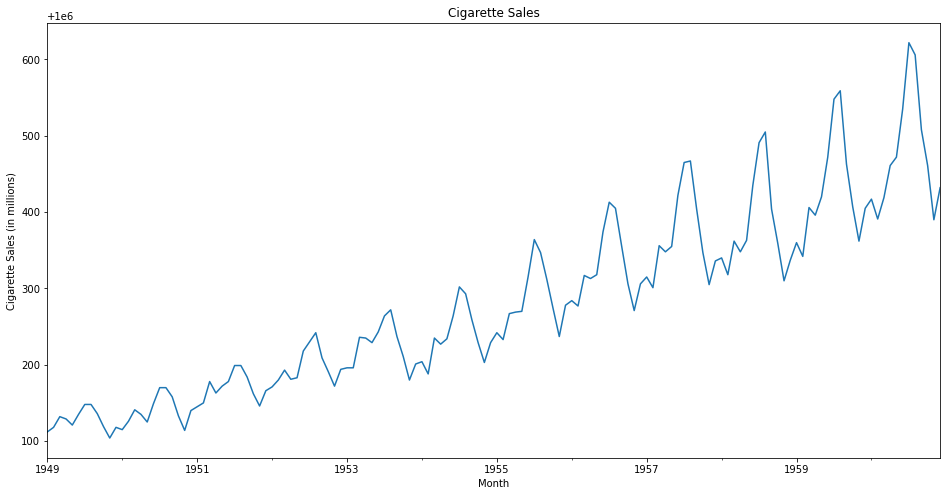

In [21]:
_ = y.plot(figsize=(16,8))
plt.ylabel('Cigarette Sales (in millions)')
_ = plt.title('Cigarette Sales')

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

  * There are consistent peaks and valleys during every year.
  * These appear to be seasonal fluctuations: sales are lowest towards the end of each year, before rising steadily to peak 1, then dipping slightly during the middle of the year, before rising again to a higher peak 2 and then falling off after.
  * In later years, the second and highest peak is much higher than the first. In fact, the range between the low and high of the cigarette sales increases every year.
  * The valleys and peaks increase every year from 1949 to 1960

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

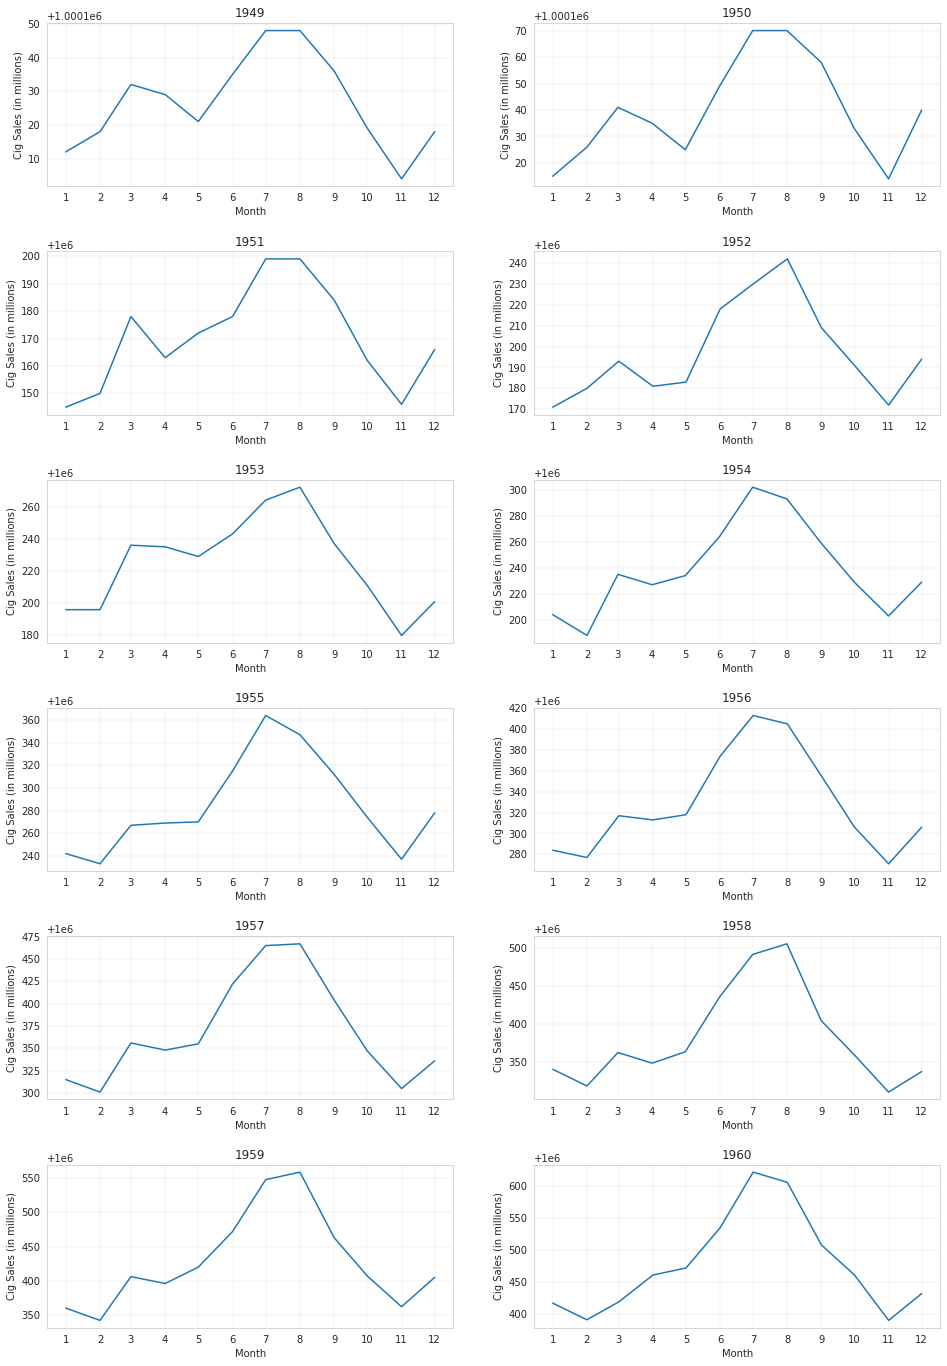

In [22]:
# plot every year in its own subplot
month_list = [i for i in range(1,13)]
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(6, 2, figsize=(16,24), squeeze=False)
    fig.subplots_adjust(wspace=0.2, hspace=0.4)
    for i, year in enumerate(range(1949,1961)):
        ax = axes.flatten()[i]
        yt = y['{0}'.format(year)]
        g = sns.lineplot(yt.index, yt.values, ax=ax)
        ax.set(xlabel='Month', ylabel='Cig Sales (in millions)')
        ax.set_xticks(yt.index)#, minor=True)
        ax.set_xticklabels(month_list)#, minor=True)
        ax.grid(b=True, which='both', color='gray', linewidth=0.1)
        ax.title.set_text(year)

__We tend to see low sales in November, January, and February, with slight uptick in December. We see a slight increase in sales during March, April, and May, and then peak sales occur around July and August. Some possible reasons for these seasonal trends:__

  * Smoking tends to occur outdoors, and since winter months are colder, fewer cigarettes are purchased.
  * The slight uptick in December may be from the stress of the holidays.
  * Longer days in the summer may mean more time for smoking.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

__We appear to have a *multiplicative* model, since the amplitude of the seasonality increases over time.__

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

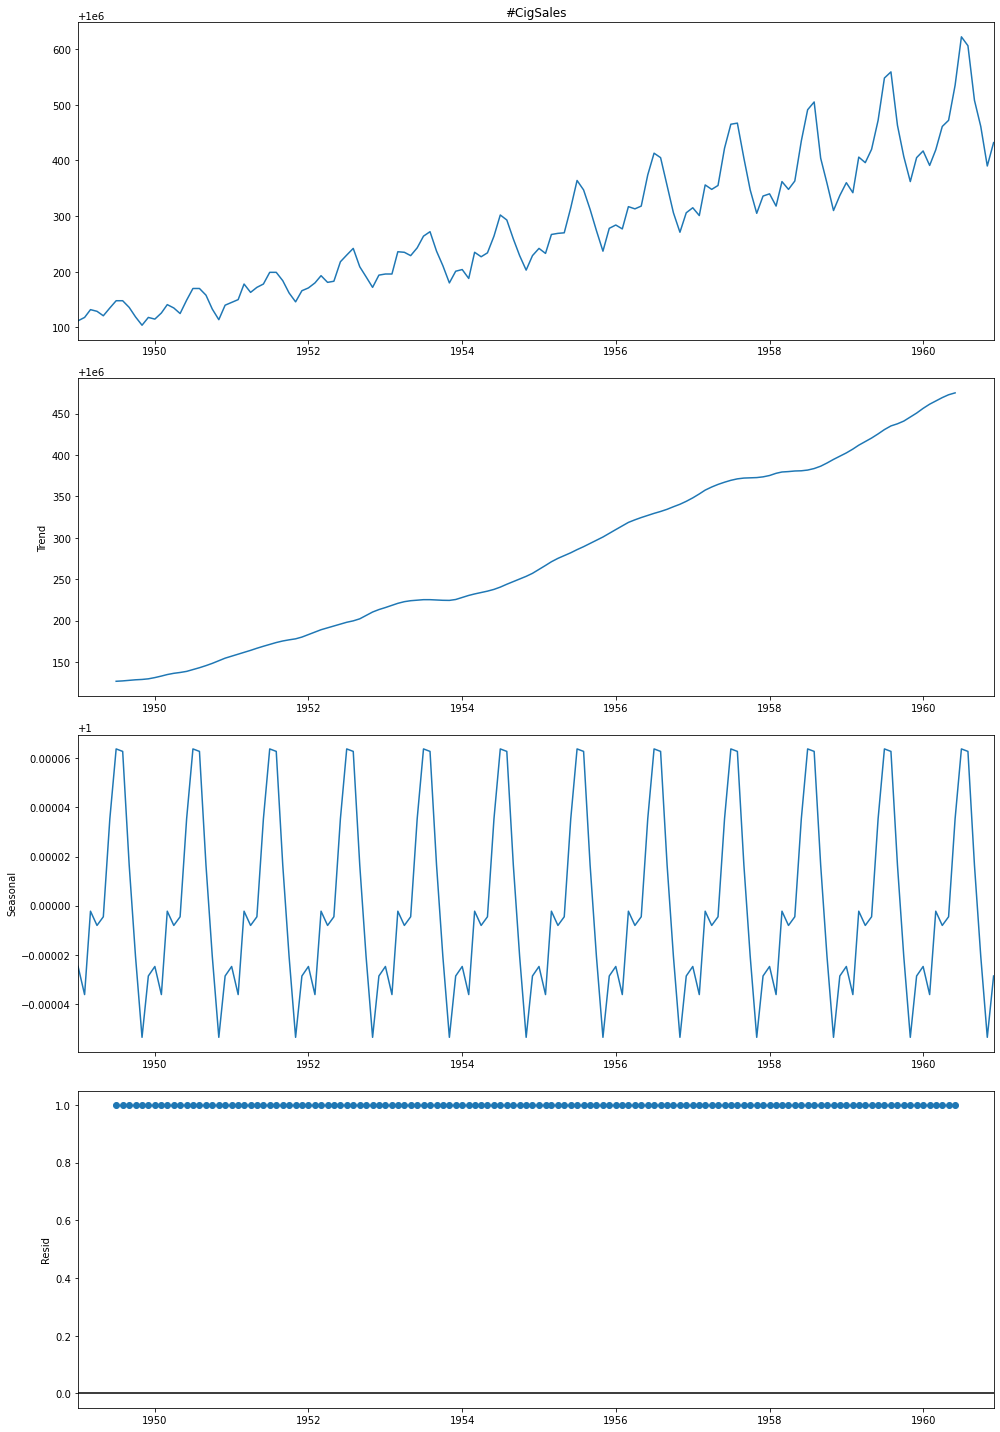

In [23]:
import statsmodels.api as sm
import matplotlib as mpl

# Plot the original data, the trend, the seasonality, and the residuals 
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')


with mpl.rc_context():
    mpl.rc("figure", figsize=(14,20))
    decomposition.plot()

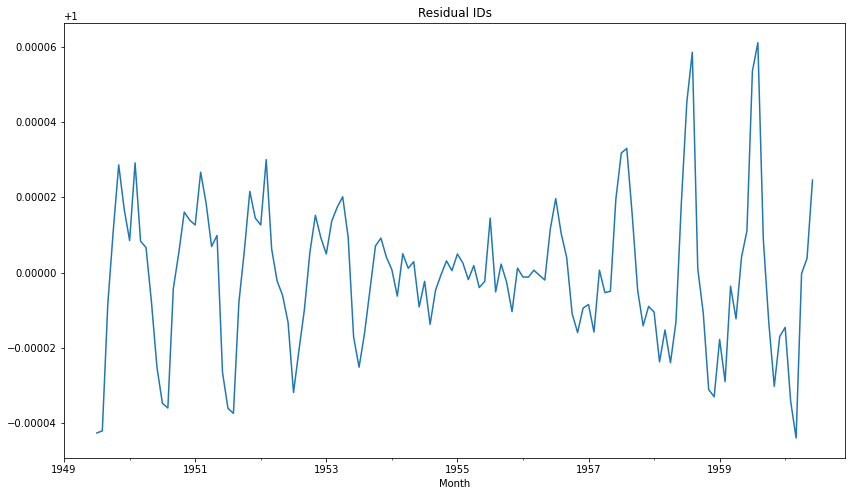

In [24]:
# take a better look at the residual plot
_ = decomposition.resid.plot(title='Residual IDs', figsize=(14,8))

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [25]:
from statsmodels.tsa.stattools import kpss

kpss_results = kpss(y, nlags='auto')
kpss_output = ['Test Statistic','p-value','Lags Used']
for i, x in enumerate(kpss_output):
    print('{0: <21} : {1}'.format(x, kpss_results[i]) )
for k,v in kpss_results[3].items():
    print('Critical Value ({0: <4}) : {1}'.format(k,v))

Test Statistic        : 1.651312235417082
p-value               : 0.01
Lags Used             : 8
Critical Value (10% ) : 0.347
Critical Value (5%  ) : 0.463
Critical Value (2.5%) : 0.574
Critical Value (1%  ) : 0.739


C:\Users\fonta\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

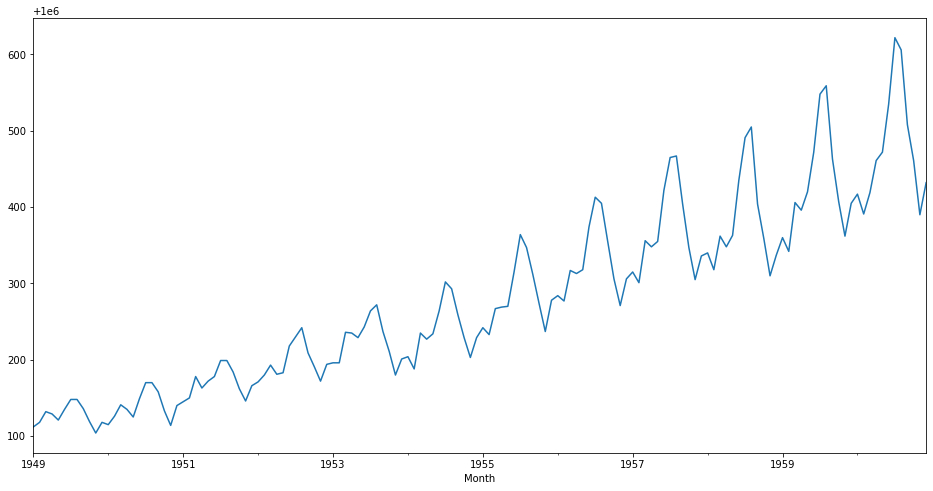

In [26]:
_ = y.plot(figsize=(16,8))

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One often  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [27]:
y_log = np.log(y).dropna()


When you plot this, you can see how the variance in our data now remains constant over time.

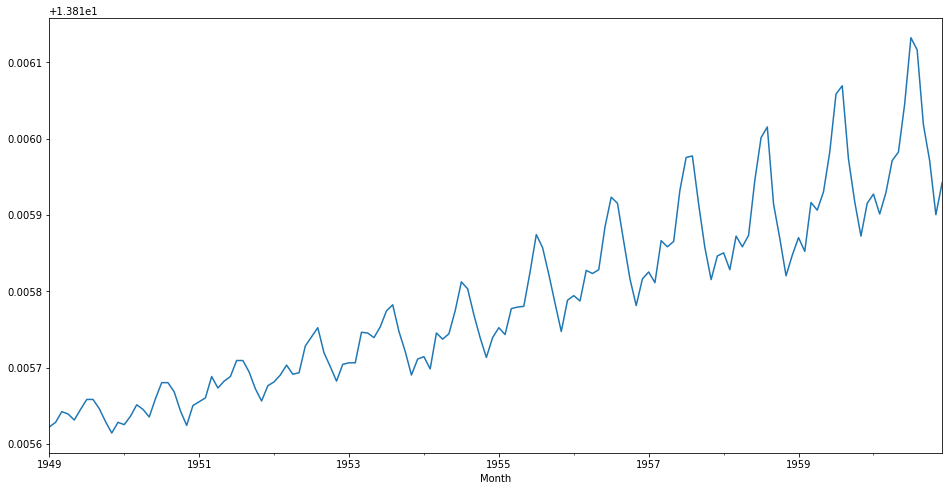

In [28]:
_ = y_log.plot(figsize=(16,8))

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [29]:
y_log_diff = y_log.diff()
y_log_diff.head()

Month
1949-01-01         NaN
1949-02-01    0.000006
1949-03-01    0.000014
1949-04-01   -0.000003
1949-05-01   -0.000008
Freq: MS, Name: #CigSales, dtype: float64

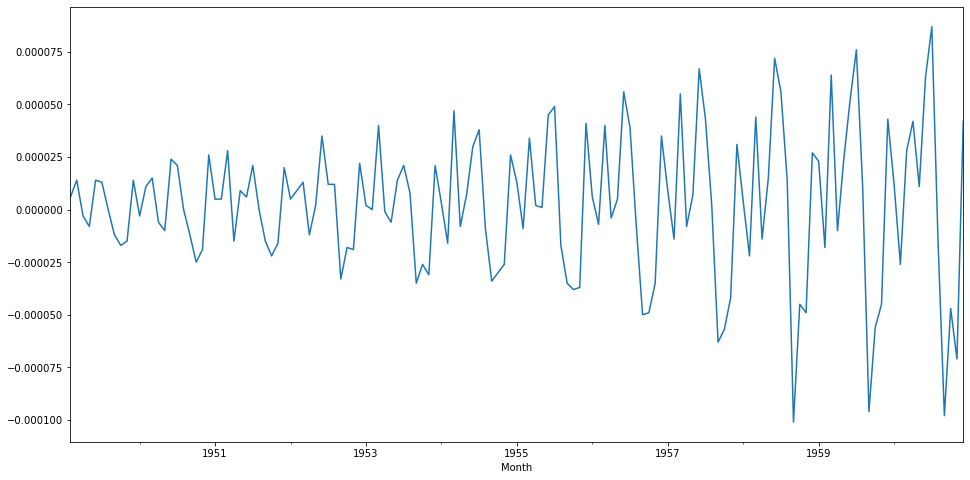

In [30]:
y_log_diff.dropna(inplace=True)
_ = y_log_diff.plot(figsize=(16,8))

In [31]:
kpss_results = kpss(y_log_diff, nlags='auto')
kpss_output = ['Test Statistic','p-value','Lags Used']
for i, x in enumerate(kpss_output):
    print('{0: <21} : {1}'.format(x, kpss_results[i]) )
for k,v in kpss_results[3].items():
    print('Critical Value ({0: <4}) : {1}'.format(k,v))

Test Statistic        : 0.02389767420757057
p-value               : 0.1
Lags Used             : 7
Critical Value (10% ) : 0.347
Critical Value (5%  ) : 0.463
Critical Value (2.5%) : 0.574
Critical Value (1%  ) : 0.739


C:\Users\fonta\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The <s>ARIMA</s> SARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

__It would appear that the best model is SARIMA, instead of ARIMA, since the data is seasonal. By using the *pmdarima* library, we can call *auto_arima* to determine the best p, d, q values.__

In [32]:
import pmdarima as pm

pm.auto_arima(y, m=12, seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -509.647
Date:                            Wed, 14 Apr 2021   AIC                           1025.294
Time:                                    22:30:15   BIC                           1033.920
Sample:                                         0   HQIC                          1028.799
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1687      0.048     -3.488      0.000      -0.263      -0.074
ar.S.L12      -0.0962      0.083     -1.161      0.246      -0.259       0.066
sigma2       132.4803     13.264      9.988      0.000     106.483     158.478
===================================================================================
Ljung-Box (Q):                       52.84   Jarque-Bera (JB):                16.08
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                             0.16
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [33]:
# Make a function to find the MSE of a single ARIMA model 
## this isn't necessary, auto_arima tries to minimize AIC (Akaike Information Critera)

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [34]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
## again, this isn't necessary, as auto_arima does this for us
## for completeness, we can see the results of each parameter

stepwise_fit = pm.auto_arima(y, 
                   start_p=0, start_q=0, max_p=3, max_q=3, 
                   m=12,
                   start_P=0, d=1, D=1,
                   error_action='ignore', 
                   trace=True,
                   suppress_warnings=True, # don't want convergence warnings
                   maxiter=10,
                   seasonal=True, 
                   stepwise=True )

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1030.996, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1025.294, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1025.566, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1025.527, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1026.800, Time=0.31 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1026.984, Time=0.25 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1025.502, Time=0.17 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=1028.434, Time=0.51 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1030.876, Time=0.11 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1027.285, Time=0.19 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1027.282, Time=0.18 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1025.341, Time=0.12 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1029.276, Time=0.20 sec
 ARIMA(1,1,0)(1,1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -509.647
Date:                            Wed, 14 Apr 2021   AIC                           1025.294
Time:                                    22:30:18   BIC                           1033.920
Sample:                                         0   HQIC                          1028.799
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1687      0.048     -3.488      0.000      -0.263      -0.074
ar.S.L12      -0.0962      0.083     -1.161      0.246      -0.259       0.066
sigma2       132.4803     13.264      9.988      0.000     106.483     158.478
===================================================================================
Ljung-Box (Q):                       52.84   Jarque-Bera (JB):                16.08
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                             0.16
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So the best p,d, q, parameters for our <s>ARIMA model are 2, 1, 1</s> __SARIMA model are 1, 1, 0__ respectively. Now we know this, we can build the model.

In [35]:
#from pmdarima import model_selection
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit the model
model = SARIMAX(y, order=(1,1,0), seasonal_order=(1,1,0,12), freq='MS')
model_fit = model.fit()

We can take a look at a summary of the model this library has built around our data.

In [36]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          #CigSales   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -509.647
Date:                            Wed, 14 Apr 2021   AIC                           1025.294
Time:                                    22:30:18   BIC                           1033.920
Sample:                                01-01-1949   HQIC                          1028.799
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1687      0.048     -3.488      0.000      -0.263      -0.074
ar.S.L12      -0.0962      0.083     -1.161      0.246      -0.259       0.066
sigma2       132.4803     13.264      9.988      0.000     106.483     158.478
===================================================================================
Ljung-Box (Q):                       52.84   Jarque-Bera (JB):                16.08
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                             0.16
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
# check the mse
model_fit.mse

8682714088.800272

In [38]:
# predict the results
pred = model_fit.predict()[24:]

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

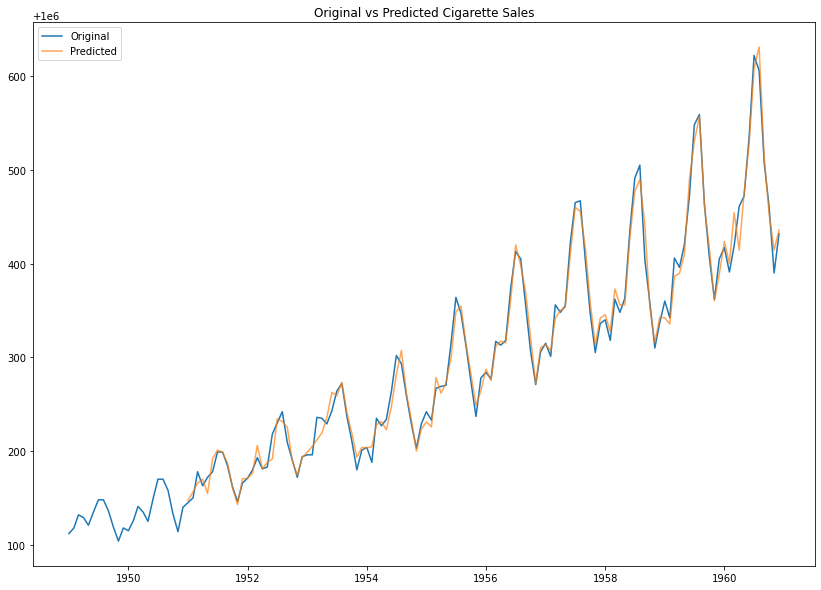

In [39]:
plt.figure(figsize=(14,10))

plt.title('Original vs Predicted Cigarette Sales')
plt.plot(y, label='Original')
plt.plot(pred, label='Predicted', alpha=0.7)

_ = plt.legend()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

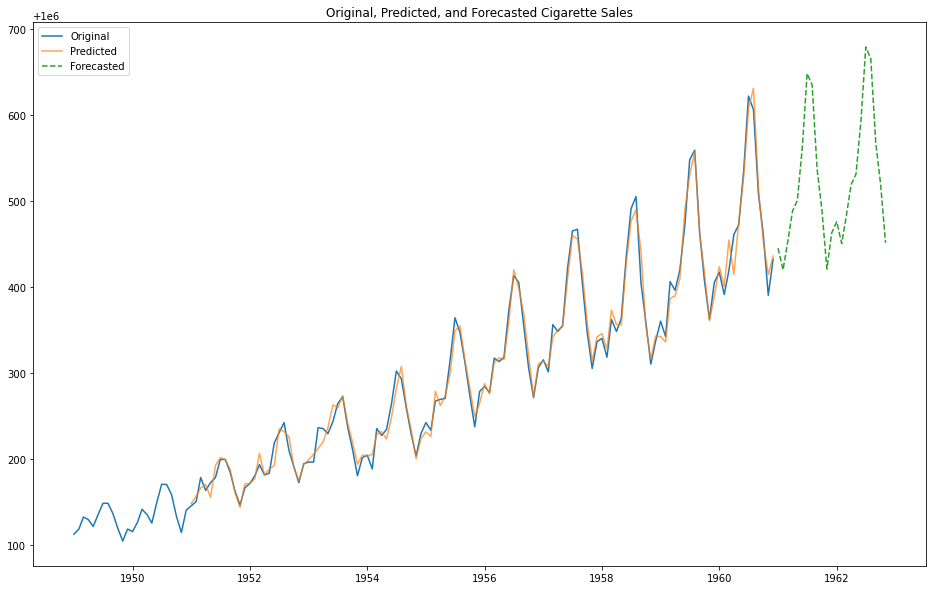

In [41]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 24
forecast_date_range = pd.date_range(y.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
future_data = pd.DataFrame(forecast_date_range, columns=['Month'])
future_data.Month = pd.to_datetime(future_data.Month)
future_data.set_index('Month', inplace = True)
future_data['Prediction'] = model_fit.forecast(forecast_period)

# Plot your future predictions
plt.figure(figsize=(16,10))

plt.title('Original, Predicted, and Forecasted Cigarette Sales')
plt.plot(y, label='Original')
plt.plot(pred, label='Predicted', alpha=0.7)
plt.plot(future_data, label='Forecasted', ls='--')

_ = plt.legend()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 